# Gamma Exploration Notebook

## What is Gamma $(\Gamma)$?

Gamma measures how much the delta changes for every $\$1.00$ change in the underlying security's price. This makes it the second derivative of the option price with respect to the stock price.

## Example

$\Gamma = 0.6$

When the underlying stock goes up $\$1$, the option's delta increases by $0.6$, meaning the option gains $\$0.60$ in value.

In [1]:
# Point A
stock_A = 100
option_A = 50

In [2]:
# Point B
stock_B = 101
option_B = 50.55

In [3]:
# Point C
stock_C = 102
option_C = 51.10

Here we can calculate delta using our formula: $\Delta = \frac{\partial C}{\partial S}$

In [4]:
delta_AB = (option_B - option_A) / (stock_B - stock_A)
delta_BC = (option_C - option_B) / (stock_C - stock_B)

print(f"Delta from A to B: {delta_AB:.2f}")
print(f"Delta from B to C: {delta_BC:.2f}")

Delta from A to B: 0.55
Delta from B to C: 0.55


## Formulas

Here we can see that Gamma $(\Gamma)$ is the change in delta (rate of change of the option price with respect to the stock price)

**Formal Definition**

$$\Gamma = \frac{\partial^2C}{\partial S^2} = \frac{\partial \Delta}{\partial S}$$

**Practical Definition**

$$\Gamma = \frac{\text{change in delta}}{\text{change in stock price}}$$

In [5]:
gamma_AB = (delta_BC - delta_AB) / (stock_B - stock_A)
print('Gamma: ' + format(gamma_AB, '.2e'))

Gamma: 7.11e-15


We can create a function to help us calculate gamma in the future and this will be saved in ```src/formulas.py``` for later use

In [6]:
def calculate_gamma(s1, s2, s3, d1, d2):
    """
    Calculate gamma as the rate of change of delta with respect to the underlying price.
    
    Args:
        s1: First stock price
        s2: Second stock price
        s3: Third stock price (middle price point)
        d1: Delta calculated from first and second price points
        d2: Delta calculated from second and third price points
    
    Returns:
        The calculated gamma value
    """
    delta_change = d2 - d1
    stock_change = s3 - s1
    
    return delta_change / stock_change

## Delta and Gamma Simulation

Gamma $(\Gamma)$ is the derivative of Delta $(\Delta)$, and Delta is the derivative of the option price with respect to the underlying stock price. 

Using synthetic market data, we can calculate Delta and Gamma to better understand their behavior and relationship.

In [7]:
import random
import math
import matplotlib.pyplot as plt
import sys
import os

# Add the parent directory to the path so we can import from src
sys.path.append(os.path.join(os.getcwd(), '..'))

from src.formulas import calculate_delta

## The Issue with Synthetic Market Data

Time to create our own stock and option prices so we can play around with delta and gamma calculations without needing real market data.

### Our Problem

Since delta is only the first derivative of option price with respect to the underlying value of the stock, we were able to control it better in our first exploration `01_delta_exploration.ipynb`. However, now that we are using gamma, simulating market data becomes a little bit more difficult.

### Synthetic Data Comes With Random Noise

Setting up some data to find the relationship between stock price and option price.

Looking at your math, let's verify the calculations with the values shown in your table:

| Index | A | B | C |
|-------|---|---|---|
| Stock Price | $100 | $101 | $102 |
| Option Price | $10.00 | $10.40 | $10.90 |

$$\Delta_{AB} = \frac{10.40 - 10.00}{101 - 100} = \frac{0.40}{1} = 0.40$$

$$\Delta_{BC} = \frac{10.90 - 10.40}{102 - 101} = \frac{0.50}{1} = 0.50$$

$$\Gamma = \frac{\Delta_{BC} - \Delta_{AB}}{102 - 100} = \frac{0.50 - 0.40}{2} = \frac{0.10}{2} = 0.05$$

Now let's add some price noise to simulate randomness. I will change/offset each of the option price values by $\pm \$0.01$:

| Index | A | B | C |
|-------|---|---|---|
| Stock Price | $100 | $101 | $102 |
| Option Price | $10.00 | $10.40 | $10.90 |
| Noisy Option Price | $10.01 | $10.39 | $10.91 |

Redoing the calculations with the noisy data:

$$\Delta_{AB\text{-noisy}} = \frac{10.39 - 10.01}{101 - 100} = \frac{0.38}{1} = 0.38$$

$$\Delta_{BC\text{-noisy}} = \frac{10.91 - 10.39}{102 - 101} = \frac{0.52}{1} = 0.52$$

$$\Gamma_{\text{noisy}} = \frac{\Delta_{BC\text{-noisy}} - \Delta_{AB\text{-noisy}}}{102 - 100} = \frac{0.52 - 0.38}{2} = \frac{0.14}{2} = 0.07$$

Notice how just $\pm \$0.01$ of noise dramatically changed our gamma from $0.05$ to $0.07$ - a **40% increase**! This demonstrates why gamma calculations are so sensitive to market noise, making it very difficult for us to simulate market data.


## Simulating Market Data for Realistic Gamma Calculations

To generate synthetic market data that produces gamma values similar to real market scenarios, we need to account for the sensitivity of gamma to price movements and market noise. Since gamma is the second derivative of option price with respect to stock price, small fluctuations in option prices can dramatically affect gamma calculations.

To truly understand how gamma works, I want to construct the complete mathematical hierarchy by **reverse engineering** the derivative chain. Instead of randomly generating prices and hoping for realistic Greeks, I'll work backwards from target gamma values to build consistent market data.

### The Mathematical Hierarchy:

$$\text{Stock Price } (S)$$
$$\downarrow \text{ (controlled moves)}$$
$$\text{Option Price } (C)$$
$$\downarrow \text{ } \left(\frac{\partial C}{\partial S}\right)$$
$$\text{Delta } (\Delta)$$
$$\downarrow \text{ } \left(\frac{\partial \Delta}{\partial S}\right)$$
$$\text{Gamma } (\Gamma)$$

### Target for Gamma

For 1 Year (365 Day) at-the-money (ATM) options the typical gamma value range is $0.005 \leq \Gamma \leq 0.02$ for daily movements, which means that our delta values should change gradually and realistically over time.

We can estimate how much we can change our delta by rearranging the following formula:

1. $$\Gamma = \frac{\text{change in delta}}{\text{change in stock price}}$$

2. $$\text{change in delta} = \Gamma \times \text{change in stock price}$$

### Statistical Strategy for Achieving Gamma

**Setup**

1. Start with a hardcoded stock price of $S_0 = \$100.00$ and option price of $C_0 = \$10.00$ ($10\%$ of stock price)
2. Initialize delta at $\Delta_0 = 0.50$, which is typical for at-the-money options
3. Establish our target gamma range $0.005 \leq \Gamma \leq 0.02$ (realistic for daily movements)
4. **Enforce delta constraint: $0.2 \leq \Delta \leq 0.8$** (ATM options typically stay within this range)

**The Process**

5. Generate random daily price movements between $\$0.50$ and $\$2.50$ (realistic daily volatility)
6. Create a smart option pricing strategy using controlled gamma and average delta calculations

**The Improved Option Pricing Strategy**

Using formula #2 from the "Target for Gamma" section, we calculate the exact delta change based on a randomly selected gamma value within our constraints:

$$\text{delta\_change} = \text{current\_gamma} \times \text{stock\_price\_move}$$

Then calculate the option price change using the **average delta** between the old and new delta values:

$$\text{avg\_delta} = \frac{\text{old\_delta} + \text{new\_delta}}{2}$$

$$\text{option\_price\_change} = \text{stock\_price\_move} \times \text{avg\_delta}$$

**Important**: We must ensure the new delta stays within realistic ATM bounds:

$$\text{new\_delta} = \text{clamp}(\text{old\_delta} + \text{delta\_change}, 0.2, 0.8)$$

This approach ensures that:
- Gamma values stay within realistic daily ranges for ATM options
- Delta changes are directly controlled by our gamma constraints
- Option price movements are mathematically consistent with delta behavior
- **Delta remains within realistic ATM option bounds throughout the year**
- The relationship between stock movements, delta changes, and option price changes is preserved

In [8]:
# Constraints for 365 days of ATM options data
gamma_constraint_range = (0.005, 0.02)  # More realistic daily gamma range for ATM options
delta_constraint_range = (0.2, 0.8)     # ATM options typically stay in this range
price_change_range = (0.5, 2.5)         # Daily stock movements (smaller for realistic volatility)

In [9]:
# Initialize starting values for 1 year of data
stock_prices = [100]
option_prices = [10]  # 10% of stock price (typical ATM option)
deltas = [0.5]        # Start at 0.5 delta (ATM)

In [10]:
for i in range(1, 365):  # Generate 365 days of data
    # Step 1: Generate a random daily stock price movement
    stock_change = random.uniform(*price_change_range) * random.choice([-1, 1])
    new_stock_price = stock_prices[-1] + stock_change
    
    # Step 2: Use a random gamma within your constraint range
    current_gamma = random.uniform(*gamma_constraint_range)
    
    # Step 3: Calculate delta change using this gamma
    delta_change = current_gamma * stock_change
    new_delta = deltas[-1] + delta_change
    
    # Step 4: Enforce delta constraints (keep options near ATM behavior)
    new_delta = max(delta_constraint_range[0], min(delta_constraint_range[1], new_delta))
    
    # Step 5: Calculate option price using average delta
    avg_delta = (deltas[-1] + new_delta) / 2
    option_change = stock_change * avg_delta
    new_option_price = max(0.01, option_prices[-1] + option_change)
    
    # Append new values
    stock_prices.append(new_stock_price)
    deltas.append(new_delta)
    option_prices.append(new_option_price)

# Display our synthetic market data summary
print(f"Generated {len(stock_prices)} data points (1 year)")
print(f"Stock price range: ${min(stock_prices):.2f} - ${max(stock_prices):.2f}")
print(f"Option price range: ${min(option_prices):.2f} - ${max(option_prices):.2f}")
print(f"Delta range: {min(deltas):.3f} - {max(deltas):.3f}")
print(f"Stock volatility: {(max(stock_prices) - min(stock_prices)) / stock_prices[0] * 100:.1f}%")

Generated 365 data points (1 year)
Stock price range: $76.01 - $112.30
Option price range: $1.79 - $15.89
Delta range: 0.200 - 0.566
Stock volatility: 36.3%


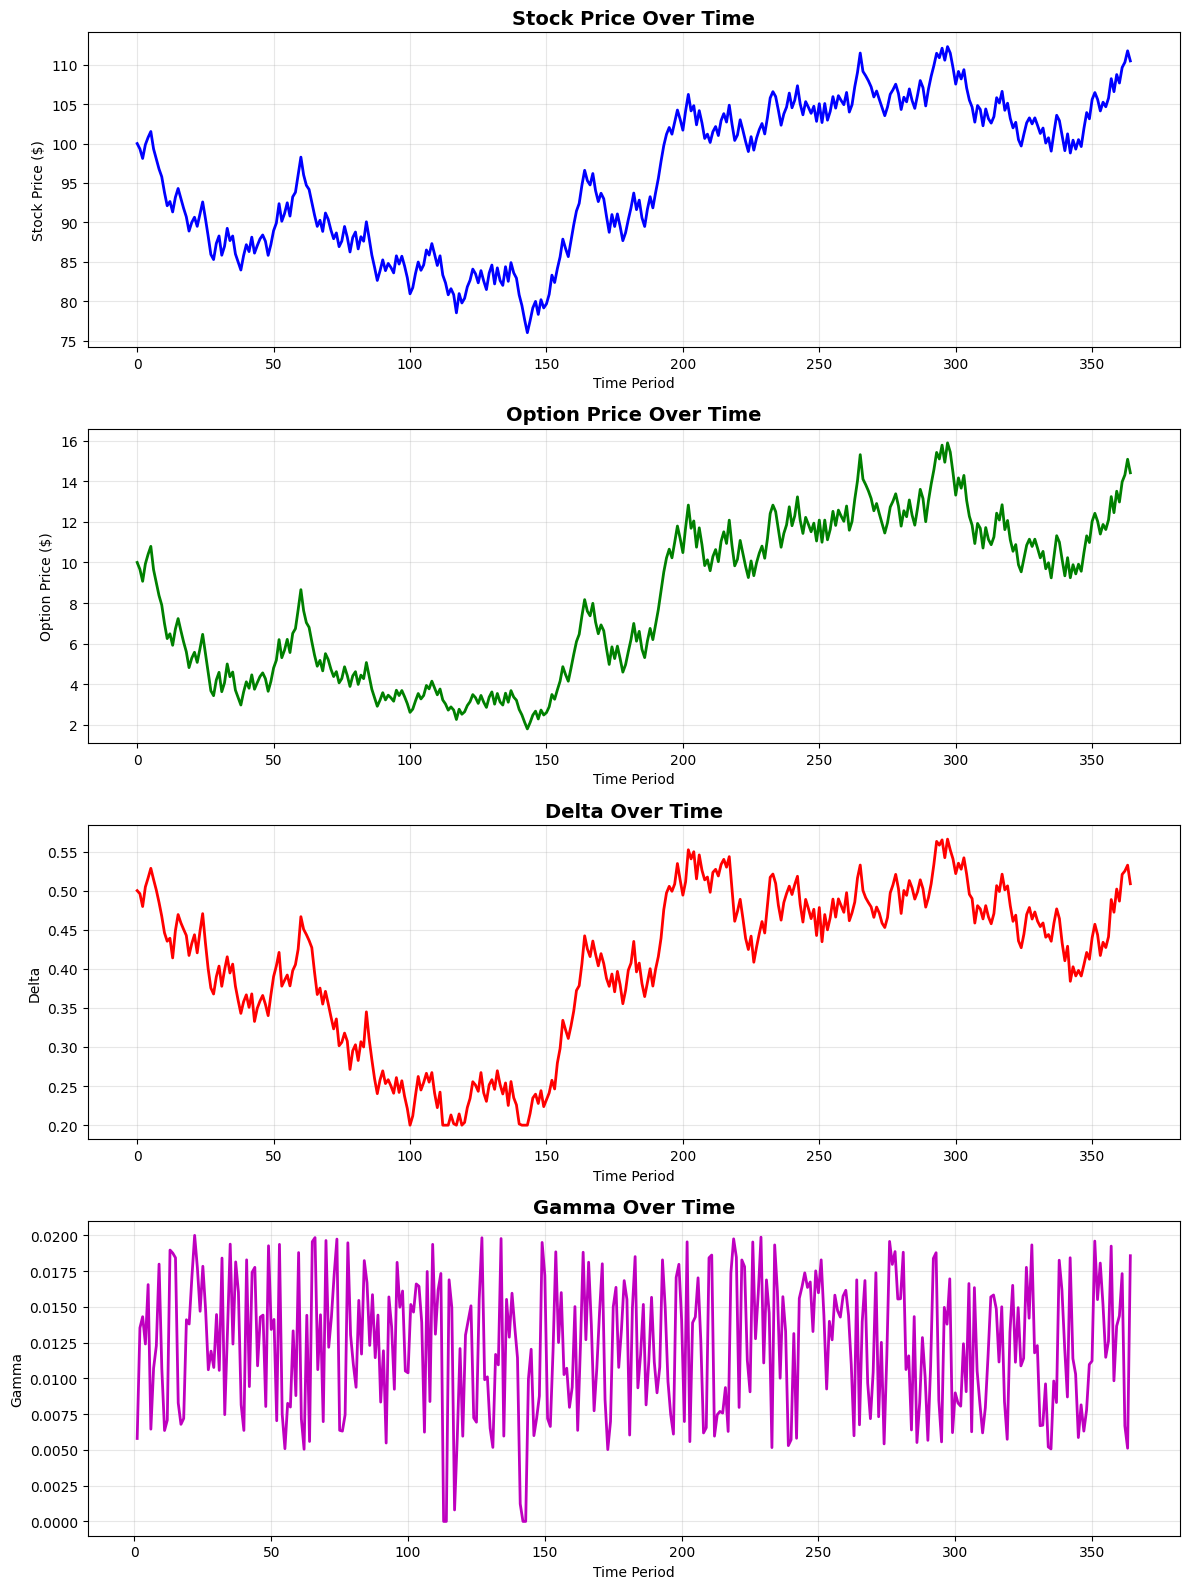

In [11]:
# Calculate gamma values from the delta changes
gammas = []
for i in range(1, len(deltas)):
    delta_change = deltas[i] - deltas[i-1]
    stock_change = stock_prices[i] - stock_prices[i-1]
    gamma = delta_change / stock_change if stock_change != 0 else 0
    gammas.append(gamma)

# Plot the four graphs
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 16))

# Graph 1: Stock Price over Time
ax1.plot(range(len(stock_prices)), stock_prices, 'b-', linewidth=2)
ax1.set_title('Stock Price Over Time', fontsize=14, fontweight='bold')
ax1.set_xlabel('Time Period')
ax1.set_ylabel('Stock Price ($)')
ax1.grid(True, alpha=0.3)

# Graph 2: Option Price over Time
ax2.plot(range(len(option_prices)), option_prices, 'g-', linewidth=2)
ax2.set_title('Option Price Over Time', fontsize=14, fontweight='bold')
ax2.set_xlabel('Time Period')
ax2.set_ylabel('Option Price ($)')
ax2.grid(True, alpha=0.3)

# Graph 3: Delta over Time
ax3.plot(range(len(deltas)), deltas, 'r-', linewidth=2)
ax3.set_title('Delta Over Time', fontsize=14, fontweight='bold')
ax3.set_xlabel('Time Period')
ax3.set_ylabel('Delta')
ax3.grid(True, alpha=0.3)

# Graph 4: Gamma over Time
ax4.plot(range(1, len(deltas)), gammas, 'm-', linewidth=2)
ax4.set_title('Gamma Over Time', fontsize=14, fontweight='bold')
ax4.set_xlabel('Time Period')
ax4.set_ylabel('Gamma')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Debrief: This Was Fun But Obviously Not How Real Markets Work

### What I Actually Learned About Gamma

This exercise really highlighted how **incredibly sensitive** gamma is to price changes. That ±$0.01 example where gamma jumped 40% shows why traders need sophisticated risk management tools.

### Why This Simulation Is Unrealistic

**This approach is wildly inaccurate** compared to actual financial markets:

1. **Real options use complex formulas** like Black-Scholes with volatility, time decay, interest rates, and dividends
2. **Markets involve psychology, news, and patterns** - not random number generation
3. **Time decay constantly affects option values** (theta), which I completely ignored
4. **Volatility sensitivity** (vega) changes option prices in ways I didn't model

### But Why This Exercise Was Still Worth It

Even with a basic simulation, I learned important concepts:
- **Gamma is extremely sensitive** - way more than I expected
- **I can see the mathematical relationships** between stock price → delta → gamma clearly
- **The Greeks interact with each other** over time in predictable ways
- **Real options trading requires deep understanding** of these sensitivities

### What's Next

I'm only examining **delta and gamma** here. In future notebooks, I'll explore the other Greeks:
- **Theta** (time decay sensitivity)
- **Vega** (volatility sensitivity) 
- **Rho** (interest rate sensitivity)

Real options pricing involves ALL the Greeks working together, so this analysis is just the beginning.

### Key Takeaway

Gamma being a second derivative makes it much more volatile than delta. This shows why options trading requires solid mathematical foundations and why my simplified approach only scratches the surface of actual market complexity.
